In [36]:
import numpy as np
import pandas as pd
from money_parser import price_dec
import censusgeocode as cg

pd.options.display.max_columns = None

In [6]:
crimes_df = pd.read_csv('data/NYC_crime.csv')
census_df = pd.read_csv('data/nyc_census_tracts.csv')
census_blocks_df = pd.read_csv('data/census_block_loc.csv')

In [324]:
def curr_to_float(v): return float(price_dec(v)) if v else v
def tf_to_10(v): return 1 if v == 't' else 0
def nulls_to_0(v): return float(0 if (pd.isnull(v) or v == '') else v)

converters_to_columns = [
    (curr_to_float, ['price', 'weekly_price', 'monthly_price','security_deposit','cleaning_fee','guests_included','extra_people']),
    (tf_to_10, ['instant_bookable', 'host_is_superhost']),
    (nulls_to_0, ['bedrooms', 'bathrooms'])
]

converters = {col: conv for conv, cols in converters_to_columns for col in cols}

df = pd.read_csv('listingwithcensus.csv', index_col='id', converters=converters)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [89]:
df = pd.DataFrame(df[df['state'] =="NY"])

In [95]:
print(df['longitude'].dtypes)

float64


In [48]:
df.columns[df.columns.str.contains('price')]

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')

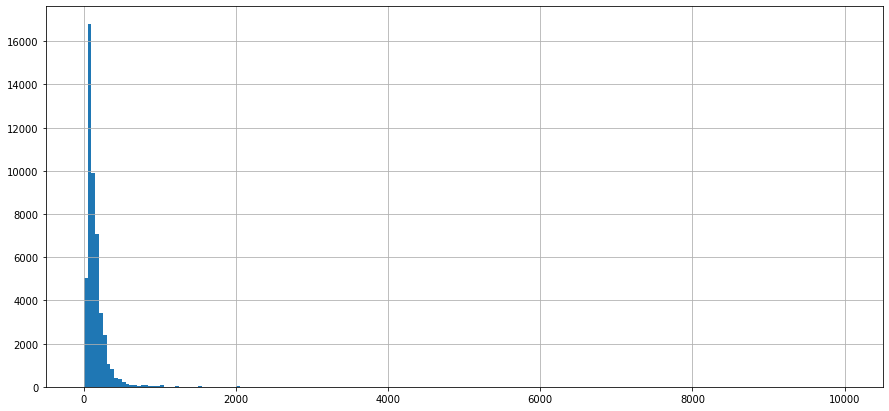

In [43]:
df['price'].map(lambda v: float(price_dec(v))).hist(bins=200, figsize=(15, 7));

In [73]:
import openapi_client
from openapi_client.rest import ApiException

def bunch(iterable, n=100):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

unique_host_names = df['host_name'].unique().tolist()
unique_host_names_dict = dict(zip(range(len(unique_host_names)), unique_host_names))
unique_host_names_rev_dict = {v: k for k, v in unique_host_names_dict.items()}

personalNameGeoIn = [{
    'id': unique_host_names_rev_dict[name],
    'name': name,
    'countryIso2': 'US'
} for name in unique_host_names]
        
personalNameGeoIn_batch_gen = bunch(personalNameGeoIn)

responses = []

configuration = openapi_client.Configuration()
configuration.api_key['X-API-KEY'] = 'beb2d6cd9009230057a169d123476090'

api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))

for batch in personalNameGeoIn_batch_gen:
    batch_personal_name_geo_in = openapi_client.BatchPersonalNameGeoIn(batch) # BatchPersonalNameGeoIn | A list of personal names, with a country ISO2 code (optional)

    try:
        api_response = api_instance.gender_full_geo_batch(batch_personal_name_geo_in=batch_personal_name_geo_in)
        responses.append(api_response)
    except ApiException as e:
        print("Exception when calling PersonalApi->gender_full_geo_batch: %s\n" % e)

In [110]:
df['census_tracts'] = np.nan

In [116]:
census_blocks_df['CensusTract'] = census_blocks_df['BlockCode'].apply(lambda v: int(str(v)[:-4]))

In [117]:
tract_to_coords_df = census_blocks_df.drop('BlockCode', axis='columns').groupby('CensusTract').mean()

In [118]:
census_all_df = tract_to_coords_df.reset_index().merge(census_df, on='CensusTract', how='right')

In [119]:
census_all_df = census_all_df[census_all_df['Latitude'].notnull()]

In [120]:
census_all_df.groupby('Borough')[['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']].mean()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr
Borough,,,,
Bronx,39504.879630,8574.972222,19537.003021,3487.350453
Brooklyn,54352.684140,11944.056452,27920.572386,4726.540214
Manhattan,83593.674074,18303.551852,69661.963768,12786.134058
Queens,62359.248050,13200.783151,27581.537984,4339.313178
Staten Island,72021.233645,13995.672897,32022.444444,4526.250000


In [12]:
census_all_df.groupby('County')[['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr']].mean()

,Income,IncomeErr,IncomePerCap,IncomePerCapErr
County,,,,
Bronx,39504.879630,8574.972222,19537.003021,3487.350453
Kings,54352.684140,11944.056452,27920.572386,4726.540214
New York,83593.674074,18303.551852,69661.963768,12786.134058
Queens,62359.248050,13200.783151,27581.537984,4339.313178
Richmond,72021.233645,13995.672897,32022.444444,4526.250000


In [112]:
df.index

Int64Index([    3647,     3831,     5022,     5099,     5121,     5178,
                5203,     5222,     5238,     5295,
            ...
            38557459, 38557492, 38558695, 38559180, 38563645, 38564068,
            38564524, 38566777, 38567542, 38568081],
           dtype='int64', name='id', length=48355)

In [159]:
#api to find the census tracts for the listings
for index, row in df.iterrows():
    if df.at[index, 'census_tracts'].isnull().values==True:
        try:
            df.at[index, 'census_tracts'] = cg.coordinates(x=row['longitude'], y=row['latitude'])['Census Tracts'][0]['GEOID']
        except Exception as e:
            continue
    else: 
        continue


AttributeError: 'numpy.float64' object has no attribute 'isnull'

In [121]:
census_all_df

,CensusTract,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,40.792756,-73.883541,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,NaN,NaN,2440.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,40.805866,-73.860278,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,40.807594,-73.851237,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,23.4,24.9,9.0,10.5,41.3,10.0,44.6,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,40.819196,-73.858040,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,36.1,26.2,4.9,13.8,37.2,5.3,45.5,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,40.801216,-73.909212,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,20.9,26.2,6.6,11.0,19.2,5.3,63.9,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
5,36005002000,40.817312,-73.865804,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,18086.0,3694.0,12023.0,2346.0,53.2,67.7,14.5,41.1,16.7,7.1,20.6,19.6,7.0,68.2,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
6,36005002300,40.809020,-73.925427,Bronx,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,14479.0,1901.0,9781.0,1460.0,54.2,68.3,20.8,36.0,33.7,3.4,6.1,5.9,0.0,74.5,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
7,36005002400,40.815380,-73.870421,Bronx,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,NaN,NaN,49365.0,2072.0,0.0,0.0,63.7,36.3,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
8,36005002500,40.806759,-73.920678,Bronx,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,17226.0,6097.0,11493.0,1714.0,50.5,62.4,15.9,36.6,24.2,8.6,14.7,12.6,2.8,62.5,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
9,36005002701,40.805628,-73.915930,Bronx,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,20153.0,5229.0,10317.0,1573.0,52.6,64.9,19.9,35.9,25.8,4.9,13.5,14.0,1.7,64.7,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2


In [161]:
df[df['census_tracts'].isnull().values==False]

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,$150.00,NaN,NaN,$200.00,$75.00,2,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN,3.606102e+10
3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,Brooklyn,Brooklyn,NY,11238,New York,"Br

In [160]:
df

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,$150.00,NaN,NaN,$200.00,$75.00,2,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN,3.606102e+10
3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,Brooklyn,Brooklyn,NY,11238,New York,"Br

In [165]:
census_all_df = census_all_df.rename(columns = {'CensusTract':'census_tracts'})

In [325]:
df1 = df.copy()

In [326]:
df1[df1['census_tracts']==36061018400]

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5022,https://www.airbnb.com/rooms/5022,20190912153101,2019-09-13,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,NaN,NaN,NaN,NaN,Please be considerate when staying in the apar...,NaN,NaN,https://a0.muscache.com/im/pictures/feb453bd-f...,NaN,7192,https://www.airbnb.com/users/show/7192,Laura,2009-01-29,"Miami, Florida, United States",I have been a NYer for almost 10 years. I came...,NaN,NaN,NaN,0,https://a0.muscache.com/im/users/7192/profile_...,https://a0.muscache.com/im/users/7192/profile_...,East Harlem,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"New York, NY, United States",East Harlem,East Harlem,Manhattan,New York,NY,10029,New York,"New York, NY",US,United States,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,0.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",NaN,80.0,600,1600,100,80,1.0,20.0,10,120,10,10,120,120,10.0,120.0,6 months ago,t,0,0,0,0,2019-09-13,9,2,2012-03-20,2018-11-19,93.0,10.0,9.0,10.0,10.0,9.0,10.0,f,NaN,NaN,0,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10,3.606102e+10
658515,https://www.airbnb.com/rooms/658515,20190912153101,2019-09-13,A nice quiet room in Manhattan,A cozy spot on the border of east harlem. lot...,"Hallo, Hi, Como estas, Konnichi wa, Bonjour......",A cozy spot on the border of east harlem. lot...,none,I like that its in the city but not in an over...,NaN,the place is near many trains 2/3/4/5/6 and m6...,Roof top.. its nice to sit and relax up there ...,If guests need anything please feel free to te...,Guest that stay are expected to be respectable...,NaN,NaN,https://a0.muscache.com/im/pictures/52457553/d...,NaN,3320650,https://www.airbnb.com/users/show/3320650,Jay,2012-08-20,"New York, New York, United States",easy going.,within a day,100%,NaN,0,https://a0.muscache.com/im/pictures/user/c9e0e...,https://a0.muscache.com/im/pictures/user/c9e0e...,East Harlem,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"New York, NY, United States",East Harlem,East Harlem,Manhattan,New York,NY,10035,New York,"New York, NY",U

In [327]:
new_df = df1.join(census_all_df.set_index('census_tracts'), on = "census_tracts")
new_df

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,0,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,150.0,,,200,75,2.0,20.0,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,0,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN,3.606102e+10,40.809020,-73.941256,New York,Manhattan,5320.0,2758.0,2562.0,11.9,21.8,53.3,0.0,7.2,3683.0,42220.0,8831.0,37019.0,7619.0,25.6,50.1,42.3,13.7,30.4,3.5,10.1,8.8,2.1,70.8,7.1,4.9,6.3,36.4,2695.0,78.7,11.1,10.2,0.0,11.0
3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be ar

In [328]:
new_df1 = new_df[new_df['census_tracts'].isnull().values==False]


In [291]:
new_df.dtypes

listing_url               object
scrape_id                  int64
last_scraped              object
name                      object
summary                   object
space                     object
description               object
experiences_offered       object
neighborhood_overview     object
notes                     object
transit                   object
access                    object
interaction               object
house_rules               object
thumbnail_url            float64
medium_url               float64
picture_url               object
xl_picture_url           float64
host_id                    int64
host_url                  object
host_name                 object
host_since                object
host_location             object
host_about                object
host_response_time        object
host_response_rate        object
host_acceptance_rate     float64
host_is_superhost         object
host_thumbnail_url        object
host_picture_url          object
          

In [329]:
df_test1 = new_df1.drop(['listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_acceptance_rate','host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','host_has_profile_pic','host_identity_verified','street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state','market','smart_location','country_code','country','property_type','room_type','bed_type','amenities','calendar_updated','calendar_last_scraped','first_review','last_review','requires_license','license','jurisdiction_names','is_business_travel_ready','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','County','Borough'],axis=1)
df_test1['host_response_rate'] = df_test1['host_response_rate'].fillna('0%')
df_test1['host_response_rate'] = df_test1['host_response_rate'].map(lambda x: str(x)[:-1])
df_test1

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts,Latitude,Longitude,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,0%,0,1.0,1.0,10027,40.80902,-73.94190,t,2,1.0,1.0,1.0,NaN,150.0,,,200,75,2.0,20.0,3,7,3,3,7,7,3.0,7.0,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,NaN,3.606102e+10,40.809020,-73.941256,5320.0,2758.0,2562.0,11.9,21.8,53.3,0.0,7.2,3683.0,42220.0,8831.0,37019.0,7619.0,25.6,50.1,42.3,13.7,30.4,3.5,10.1,8.8,2.1,70.8,7.1,4.9,6.3,36.4,2695.0,78.7,11.1,10.2,0.0,11.0
3831,92%,0,1.0,1.0,11238,40.68514,-73.95976,t,3,1.0,1.0,4.0,500.0,89.0,575,2100,500,,1.0,0.0,1,730,1,1,730,730,1.0,730.0,t,1,3,8,192,279,67,90.0,9.0,9.0,10.0,9.0,10.0,9.0,0,1,1,0,0,4.62,3.604702e+10,40.685779,-73.960251,3506.0,1711.0,1795.0,8.9,41.5,37.9,0.0,4.4,2894.0,77039.0,8111.0,36598.0,4034.0,19.0,19.7,55.3,13.9,21.7,4.8,4.4,13.4,0.0,64.4,10.6,5.5,6.1,39.8,2000.0,82.6,11.9,5.5,0.0,11.8
5022,0%,0,1.0,1.0,10029,40.79851,-73.94399,t,1,1.0,0.0,1.0,NaN,80.0,600,1600,100,80,1.0,20.0,10,120,10,10,120,120,10.0,120.0,t,0,0,0,0,9,2,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0,1,1,0,0,0.10,3.606102e+10,40.799598,-73.945477,7796.0,3487.0,4309.0,51.1,5.3,35.7,0.0,6.2,5126.0,25581.0,3819.0,20311.0,4797.0,33.2,47.1,32.2,27.1,27.0,1.4,12.3,14.5,2.6,70.3,8.8,1.7,2.1,36.6,2946.0,84.0,14.1,1.9,0.0,9.6
5099,78%,0,1.0,1.0,10016,40.74767,-73.97500,f,2,1.0,1.0,1.0,NaN,200.0,,,300,125,2.0,100.0,3,21,3,3,21,21,3.0,21.0,t,3,3,13,13,75,10,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0,1,1,0,0,0.59,3.606101e+10,40.746834,-73.974497,8032.0,3342.0,4690.0,6.3,69.2,3.5,0.0,18.8,6105.0,120205.0,12734.0,93503.0,10726.0,7.6,0.0,64.5,4.4,27.5,3.2,0.4,2.5,0.4,41.7,43.7,5.6,6.1,29.6,5491.0,92.1,3.6,4.2,0.0,6.9
5121,0%,0,1.0,1.0,11216,40.68688,-73.95596,f,2,0.0,1.0,1.0,NaN,60.0,,,450,0,1.0,30.0,45,730,45,45,730,730,45.0,730.0,t,0,0,0,0,49,0,90.0,8.0,8.0,10.0,10.0,9.0,9.0,0,1,0,1,0,0.39,3.604702e+10,40.684648,-73.957085,3780.0,1754.0,2026.0,5.3,32.3,51.0,0.0,7.8,2793.0,51645.0,13885.0,32422.0,4716.0,19.3,26.3,54.0,13.4,20.3,1.8,10.5,10.2,1.4,67.7,4.4,8.4,7.7,37.5,2143.0,86.0,9.8,4.2,0.0,8.0
5178,90%,0,1.0,1.0,10019,40.76489,-73.98493,t,2,1.0,1.0,1.0,NaN,79.0,470,,,15,1.0,12.0,2,14,1,2,14,14,1.8,14.0,t,1,5,10,246,443,49,83.0,8.0,7.0,9.0,9.0,10.0,8.0,0,1,0,1,0,3.51,3.606101e+10,40.764925,-73.987161,4858.0,2572.0,2286.0,22.8,56.1,4.0,0.3,15.0,3842.0,81974.0,18456.0,64861.0,8324.0,14.5,0.0,67.0,11.3,19.0,0.6,2.2,4.0,0.4,50.5,35.4,6.4,3.3,25.3,3261.0,88.3,5.2,6.4,0.0,7.9
5203,0%,0,1.0,1.0,10025,40.80178,-73.96723,t,1,1.0,1.0,1.0,NaN,79.0,,,,,1.0,0.0,2,14,2,2,14,14,2.0,14.0,t,0,0,0,0,118,0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,1,0,0.97,3.606102e+10,40.803819,-73.970382,7608.0,3374.0,4234.0,18.2,65.6,1.7,0.0,12.3,5530.0,117045.0,25802.0,71348.0,9226.0,12.3,4.8,74.2,8.2,13.3,1.7,2.6,6.0,1.0

In [330]:
df_test1['host_response_rate'] = df_test1['host_response_rate'].map(lambda x: str(x)[:-1])
# df_test1['price'] = df_test1['price'].map(lambda x: str(x)[1:])
df_test1

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts,Latitude,Longitude,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,0,0,1.0,1.0,10027,40.80902,-73.94190,t,2,1.0,1.0,1.0,NaN,150.0,,,200,75,2.0,20.0,3,7,3,3,7,7,3.0,7.0,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,NaN,3.606102e+10,40.809020,-73.941256,5320.0,2758.0,2562.0,11.9,21.8,53.3,0.0,7.2,3683.0,42220.0,8831.0,37019.0,7619.0,25.6,50.1,42.3,13.7,30.4,3.5,10.1,8.8,2.1,70.8,7.1,4.9,6.3,36.4,2695.0,78.7,11.1,10.2,0.0,11.0
3831,92,0,1.0,1.0,11238,40.68514,-73.95976,t,3,1.0,1.0,4.0,500.0,89.0,575,2100,500,,1.0,0.0,1,730,1,1,730,730,1.0,730.0,t,1,3,8,192,279,67,90.0,9.0,9.0,10.0,9.0,10.0,9.0,0,1,1,0,0,4.62,3.604702e+10,40.685779,-73.960251,3506.0,1711.0,1795.0,8.9,41.5,37.9,0.0,4.4,2894.0,77039.0,8111.0,36598.0,4034.0,19.0,19.7,55.3,13.9,21.7,4.8,4.4,13.4,0.0,64.4,10.6,5.5,6.1,39.8,2000.0,82.6,11.9,5.5,0.0,11.8
5022,0,0,1.0,1.0,10029,40.79851,-73.94399,t,1,1.0,0.0,1.0,NaN,80.0,600,1600,100,80,1.0,20.0,10,120,10,10,120,120,10.0,120.0,t,0,0,0,0,9,2,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0,1,1,0,0,0.10,3.606102e+10,40.799598,-73.945477,7796.0,3487.0,4309.0,51.1,5.3,35.7,0.0,6.2,5126.0,25581.0,3819.0,20311.0,4797.0,33.2,47.1,32.2,27.1,27.0,1.4,12.3,14.5,2.6,70.3,8.8,1.7,2.1,36.6,2946.0,84.0,14.1,1.9,0.0,9.6
5099,78,0,1.0,1.0,10016,40.74767,-73.97500,f,2,1.0,1.0,1.0,NaN,200.0,,,300,125,2.0,100.0,3,21,3,3,21,21,3.0,21.0,t,3,3,13,13,75,10,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0,1,1,0,0,0.59,3.606101e+10,40.746834,-73.974497,8032.0,3342.0,4690.0,6.3,69.2,3.5,0.0,18.8,6105.0,120205.0,12734.0,93503.0,10726.0,7.6,0.0,64.5,4.4,27.5,3.2,0.4,2.5,0.4,41.7,43.7,5.6,6.1,29.6,5491.0,92.1,3.6,4.2,0.0,6.9
5121,0,0,1.0,1.0,11216,40.68688,-73.95596,f,2,0.0,1.0,1.0,NaN,60.0,,,450,0,1.0,30.0,45,730,45,45,730,730,45.0,730.0,t,0,0,0,0,49,0,90.0,8.0,8.0,10.0,10.0,9.0,9.0,0,1,0,1,0,0.39,3.604702e+10,40.684648,-73.957085,3780.0,1754.0,2026.0,5.3,32.3,51.0,0.0,7.8,2793.0,51645.0,13885.0,32422.0,4716.0,19.3,26.3,54.0,13.4,20.3,1.8,10.5,10.2,1.4,67.7,4.4,8.4,7.7,37.5,2143.0,86.0,9.8,4.2,0.0,8.0
5178,90,0,1.0,1.0,10019,40.76489,-73.98493,t,2,1.0,1.0,1.0,NaN,79.0,470,,,15,1.0,12.0,2,14,1,2,14,14,1.8,14.0,t,1,5,10,246,443,49,83.0,8.0,7.0,9.0,9.0,10.0,8.0,0,1,0,1,0,3.51,3.606101e+10,40.764925,-73.987161,4858.0,2572.0,2286.0,22.8,56.1,4.0,0.3,15.0,3842.0,81974.0,18456.0,64861.0,8324.0,14.5,0.0,67.0,11.3,19.0,0.6,2.2,4.0,0.4,50.5,35.4,6.4,3.3,25.3,3261.0,88.3,5.2,6.4,0.0,7.9
5203,0,0,1.0,1.0,10025,40.80178,-73.96723,t,1,1.0,1.0,1.0,NaN,79.0,,,,,1.0,0.0,2,14,2,2,14,14,2.0,14.0,t,0,0,0,0,118,0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,1,0,0.97,3.606102e+10,40.803819,-73.970382,7608.0,3374.0,4234.0,18.2,65.6,1.7,0.0,12.3,5530.0,117045.0,25802.0,71348.0,9226.0,12.3,4.8,74.2,8.2,13.3,1.7,2.6,6.0,1.0,76.0,7

In [321]:
df_test1.dtypes

host_response_rate            object
host_is_superhost              int64
host_listings_count          float64
host_total_listings_count    float64
zipcode                       object
latitude                     float64
longitude                    float64
is_location_exact             object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
square_feet                  float64
price                        float64
weekly_price                  object
monthly_price                 object
security_deposit              object
cleaning_fee                  object
guests_included                int64
extra_people                  object
minimum_nights                 int64
maximum_nights                 int64
minimum_minimum_nights         int64
maximum_minimum_nights         int64
minimum_maximum_nights         int64
maximum_maximum_nights         int64
minimum_nights_avg_ntm       float64
m

In [331]:
df_test2 = df_test1.drop(['zipcode'],axis = 1)
df_test2['price'] = new_df1['price']
df_test2

,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,census_tracts,Latitude,Longitude,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,0,0,1.0,1.0,40.80902,-73.94190,t,2,1.0,1.0,1.0,NaN,150.0,,,200,75,2.0,20.0,3,7,3,3,7,7,3.0,7.0,t,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,NaN,3.606102e+10,40.809020,-73.941256,5320.0,2758.0,2562.0,11.9,21.8,53.3,0.0,7.2,3683.0,42220.0,8831.0,37019.0,7619.0,25.6,50.1,42.3,13.7,30.4,3.5,10.1,8.8,2.1,70.8,7.1,4.9,6.3,36.4,2695.0,78.7,11.1,10.2,0.0,11.0
3831,92,0,1.0,1.0,40.68514,-73.95976,t,3,1.0,1.0,4.0,500.0,89.0,575,2100,500,,1.0,0.0,1,730,1,1,730,730,1.0,730.0,t,1,3,8,192,279,67,90.0,9.0,9.0,10.0,9.0,10.0,9.0,0,1,1,0,0,4.62,3.604702e+10,40.685779,-73.960251,3506.0,1711.0,1795.0,8.9,41.5,37.9,0.0,4.4,2894.0,77039.0,8111.0,36598.0,4034.0,19.0,19.7,55.3,13.9,21.7,4.8,4.4,13.4,0.0,64.4,10.6,5.5,6.1,39.8,2000.0,82.6,11.9,5.5,0.0,11.8
5022,0,0,1.0,1.0,40.79851,-73.94399,t,1,1.0,0.0,1.0,NaN,80.0,600,1600,100,80,1.0,20.0,10,120,10,10,120,120,10.0,120.0,t,0,0,0,0,9,2,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0,1,1,0,0,0.10,3.606102e+10,40.799598,-73.945477,7796.0,3487.0,4309.0,51.1,5.3,35.7,0.0,6.2,5126.0,25581.0,3819.0,20311.0,4797.0,33.2,47.1,32.2,27.1,27.0,1.4,12.3,14.5,2.6,70.3,8.8,1.7,2.1,36.6,2946.0,84.0,14.1,1.9,0.0,9.6
5099,78,0,1.0,1.0,40.74767,-73.97500,f,2,1.0,1.0,1.0,NaN,200.0,,,300,125,2.0,100.0,3,21,3,3,21,21,3.0,21.0,t,3,3,13,13,75,10,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0,1,1,0,0,0.59,3.606101e+10,40.746834,-73.974497,8032.0,3342.0,4690.0,6.3,69.2,3.5,0.0,18.8,6105.0,120205.0,12734.0,93503.0,10726.0,7.6,0.0,64.5,4.4,27.5,3.2,0.4,2.5,0.4,41.7,43.7,5.6,6.1,29.6,5491.0,92.1,3.6,4.2,0.0,6.9
5121,0,0,1.0,1.0,40.68688,-73.95596,f,2,0.0,1.0,1.0,NaN,60.0,,,450,0,1.0,30.0,45,730,45,45,730,730,45.0,730.0,t,0,0,0,0,49,0,90.0,8.0,8.0,10.0,10.0,9.0,9.0,0,1,0,1,0,0.39,3.604702e+10,40.684648,-73.957085,3780.0,1754.0,2026.0,5.3,32.3,51.0,0.0,7.8,2793.0,51645.0,13885.0,32422.0,4716.0,19.3,26.3,54.0,13.4,20.3,1.8,10.5,10.2,1.4,67.7,4.4,8.4,7.7,37.5,2143.0,86.0,9.8,4.2,0.0,8.0
5178,90,0,1.0,1.0,40.76489,-73.98493,t,2,1.0,1.0,1.0,NaN,79.0,470,,,15,1.0,12.0,2,14,1,2,14,14,1.8,14.0,t,1,5,10,246,443,49,83.0,8.0,7.0,9.0,9.0,10.0,8.0,0,1,0,1,0,3.51,3.606101e+10,40.764925,-73.987161,4858.0,2572.0,2286.0,22.8,56.1,4.0,0.3,15.0,3842.0,81974.0,18456.0,64861.0,8324.0,14.5,0.0,67.0,11.3,19.0,0.6,2.2,4.0,0.4,50.5,35.4,6.4,3.3,25.3,3261.0,88.3,5.2,6.4,0.0,7.9
5203,0,0,1.0,1.0,40.80178,-73.96723,t,1,1.0,1.0,1.0,NaN,79.0,,,,,1.0,0.0,2,14,2,2,14,14,2.0,14.0,t,0,0,0,0,118,0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,1,0,0.97,3.606102e+10,40.803819,-73.970382,7608.0,3374.0,4234.0,18.2,65.6,1.7,0.0,12.3,5530.0,117045.0,25802.0,71348.0,9226.0,12.3,4.8,74.2,8.2,13.3,1.7,2.6,6.0,1.0,76.0,7.3,2.2,7.5,37.2,4306.0,81.8,6.9,10.7,0.6,6.6
5222,1

In [301]:
for index, row in new_df1.iterrows():
    new_df1.at[index, 'price'] = float(price_dec(new_df1.at[index, 'price'] ))
new_df1['price'] = new_df1['price'].astype('float')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [304]:
corr = new_df1.corr()['price']
corr = corr.sort_values().round(2)
corr

MeanCommute                                    -0.20
Service                                        -0.18
Production                                     -0.17
longitude                                      -0.14
Longitude                                      -0.14
Construction                                   -0.14
ChildPoverty                                   -0.13
Hispanic                                       -0.12
Unemployment                                   -0.12
Poverty                                        -0.12
PublicWork                                     -0.12
Transit                                        -0.12
Drive                                          -0.11
Black                                          -0.10
Carpool                                        -0.09
calculated_host_listings_count_private_rooms   -0.06
number_of_reviews_ltm                          -0.05
number_of_reviews                              -0.05
calculated_host_listings_count_shared_rooms   

In [297]:
df_test2['host_response_rate'] = df_test2['host_response_rate'].astype('int')


In [336]:
corr = abs(df_test2.corr()['price'])
corr = corr.sort_values()
corr

review_scores_communication                    0.000128
maximum_nights                                 0.000395
maximum_maximum_nights                         0.000395
maximum_nights_avg_ntm                         0.000395
minimum_maximum_nights                         0.000395
FamilyWork                                     0.002099
instant_bookable                               0.002245
host_is_superhost                              0.002654
review_scores_value                            0.008088
review_scores_accuracy                         0.008359
review_scores_checkin                          0.009421
Native                                         0.020303
Women                                          0.027731
latitude                                       0.033486
review_scores_rating                           0.033729
TotalPop                                       0.033826
Latitude                                       0.033920
maximum_minimum_nights                         0

In [334]:
df_test3 = df_test2.copy()


In [255]:
df_test3 = df_test3[['price','Income','IncomeErr','IncomePerCap','IncomePerCapErr','Professional','Walk','OtherTransp','WorkAtHome','Employed','PrivateWork',
'Poverty','ChildPoverty','Service','Construction','Production','Drive','Transit','MeanCommute','PublicWork','Unemployment']]


In [335]:
df_test3.to_csv('df_test3.csv')